### IR Wavefunction

$$
\newcommand{\ket}[1]{\vert{#1}\rangle}\\
\newcommand{\bra}[1]{\langle{#1}\vert}\\
\ket{\text{IR}} = \ket{\hat n_{k_{-2}} = \hat n_{k_{-3}} = 2} \otimes \frac{1}{2}\bigg[ \ket{\uparrow^d}\frac{1}{\sqrt 2}\left(\ket{k_1 \downarrow} + \ket{k_{-1} \downarrow}\right) - \ket{\downarrow^d}\frac{1}{\sqrt 2}\left(\ket{k_1 \uparrow} + \ket{k_{-1} \uparrow}\right) + \ket{2^d}\ket{0} - \ket{0^d}\ket{k_1 \uparrow, k_1 \downarrow,k_{-1} \uparrow,k_{-1} \downarrow}\bigg] \otimes  \ket{\hat n_{k_{2}} = \hat n_{k_{3} } = 0} = \ket{1111}\ket{0000}\\
=\frac{1}{2}\ket{0000} \otimes \left[\ket{10}\ket{0101} - \ket{01}\ket{1010} + \ket{11}\ket{0000} - \ket{00}\ket{1111}\right] \otimes \ket{1111}\\
U^\dagger_{k_+, k_-} = \frac{1}{2}\left[1 + \eta_{k_- \uparrow} + \eta^\dagger_{k_+ \uparrow} + \eta_{k_- \downarrow} + \eta^\dagger_{k_+ \downarrow}\right] \\
 \\
\eta_{k_+\beta}^\dagger = V \left[\lambda_2 \hat n_{d\overline\beta} + \lambda_1 \left( 1 - \hat n_{d \overline \beta} \right)  \right]c^\dagger_{q\beta}c_{d\beta} + \lambda_3 \sum_{k} \left\{ \frac{J}{2}\left( S_d^z \beta c^\dagger_{q\beta}c_{k\beta} + c^\dagger_{d \overline \beta}c_{d\beta}c^\dagger_{q\beta}c_{k \overline \beta}\right) + \frac{K}{2}\left( C^z_d c^\dagger_{q\beta}c_{k\beta} + c^\dagger_{q\beta}c^\dagger_{k \overline \beta}c_{d \overline \beta}c_{d\beta} \right) \right\}\\
\eta_{k_-\beta} = V^* \left[\lambda_1 \hat n_{d \overline \beta} + \lambda_2 \left( 1 - \hat n_{d \overline \beta} \right)  \right]c^\dagger_{d\beta}c_{q\beta} + \lambda_3 \sum_{k} \left\{ \frac{J}{2}\left( S_d^z \beta c^\dagger_{k\beta}c_{q\beta} + c^\dagger_{d\beta}c_{d \overline \beta}c^\dagger_{k \overline \beta}c_{q\beta}\right)+ \frac{K}{2}\left( C^z_d c^\dagger_{k\beta}c_{q\beta} + c^\dagger_{d\beta}c^\dagger_{d \overline \beta}c_{k \overline \beta}c_{q\beta} \right) \right\} \\
\lambda_1 = \frac{1}{\omega - \frac{1}{2}D + \epsilon_d + \frac{1}{2}K}, \lambda_2 = \frac{1}{\omega - \frac{1}{2}D - \epsilon_d + \frac{1}{2}J}, \lambda_3 = \frac{1}{\omega - \frac{1}{2}D + \frac{1}{4}\left(J + K\right)} 
$$

In [1]:
from qutip import *
from math import *
import itertools
from itertools import product
import matplotlib
from matplotlib import pyplot as plt

import numpy as np

font = {'size'   : 17}

matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 5, 5
#plt.rcParams['figure.dpi'] = 90
matplotlib.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True

idt = identity(2)
n = create(2) * destroy(2)

Cdz = 0.5 * (tensor(n, idt) +  tensor(idt, n) - 1)
# isospin z component

 

### Writing the impurity+cloud wavefunction

In [2]:
def get_cloud(csm, ccm):
    up = [1, 0, 0, 1, 0, 1]
    down = [0, 1, 1, 0, 1, 0]
    two = [1, 1, 0, 0, 0, 0]
    zero = [0, 0, 1, 1, 1, 1]
    cloudup = csm * tensor([basis(2,i) for i in up])
    clouddown = csm * tensor([basis(2,i) for i in down])
    cloudtwo = ccm * tensor([basis(2,i) for i in two])
    cloudzero = ccm * tensor([basis(2,i) for i in zero])
    psi_cloud = tensor(cloudup - clouddown + cloudtwo - cloudzero)
    return psi_cloud    

## Creating the unitary

$ \eta^{\dagger/-} = \eta_1^{\dagger/-} + \eta_2^{\dagger/-} + \eta_3^{\dagger/-}$

### Create $c^\dagger_{q\beta}\otimes I_{\overline\beta}$ or $c_{q\beta}\otimes I_{\overline\beta}$

In [3]:
def cq(beta, conj):
    cq_ = create(2) if conj == 1 else destroy(2)
    # use c^dagger_q is conj == 1 else c_q

    return tensor(cq_, idt) if beta == 1 else tensor(idt, cq_)
    # place cq first if beta == up else place idt first

### Creating $\sum_k c_{k\beta}$

In [4]:
def sum_k_ck(beta, conj):
    # returns \sum_{k}c_{k\beta}, the conjugate is obtained by applying .dag() on this return value

    ck = create(2) if conj == 1 else destroy(2)
    # variable conj is supposed to tell me whether i require \sum_k c^\dagger_k or \sum_k c_k

    sum=0
    num = 2 * ins
    for i in range(num):
        # outer loop shifts the position of k over all cloud momenta

        cur = 0
        for j in range(num):
            # inner loop creates the string for a particular k

            if i != j: # if not the particular k, fill with idt
                cur = tensor(cur, idt, idt) if cur !=0 else tensor(idt, idt)
            elif beta == 1: 
                # otherwise, check if spin is up or down, up goes first, down goes second
                cur = tensor(cur, ck, idt) if cur !=0 else tensor(ck, idt)
            else: 
                cur = tensor(cur, idt, ck) if cur !=0 else tensor(idt, ck)
        sum = cur if sum == 0 else sum + cur 
    return sum

### Creating first part of $\eta$

$$
V \left[\lambda_2 \hat n_{d\overline\beta} + \lambda_1 \left( 1 - \hat n_{d \overline \beta} \right)  \right]c^\dagger_{q\beta}c_{d\beta}
$$
or
$$
V^* \left[\lambda_1 \hat n_{d \overline \beta} + \lambda_2 \left( 1 - \hat n_{d \overline \beta} \right)  \right]c^\dagger_{d\beta}c_{q\beta}
$$

In [5]:
def eta1(beta, conj, args):
    c1, c2, c3, V, J, K = args
    
    c_q = cq(beta, conj)
    # gets either c^\dagger_{q\beta}\otimes identity(q\ol\beta), or c_{q\beta}iden(q\ol\beta), depending on conj=\pm 1

    betaSdz = beta * 0.5 * (tensor(n, idt) - tensor(idt, n))
    # gets \beta S_d^z

    cimp = create(2) if conj == -1 else destroy(2)
    # impurity beta operator will be c_{d\beta} if conj = 1 else c^\dagger_{d\beta}
    
    imp_part = [cimp, c2 * n + c1 * (1-n)] if beta == 1 else [c2 * n + c1 * (1-n), cimp]
    # the full impurity part will be cimp \otimes idt(2) if beta is up, else idt(2) \otimes cimp,
    # because up part comes first

    cloud_part = [idt]*2*2*ins
    # cloud electrons do not participate in this part of eta, hence just identities. 
    # (ins) is number of k states on one side of FS, *2 for both sides, another *2 for spin 

    eta_1 = V * tensor([c_q] + imp_part + cloud_part) if conj == 1 else V * tensor(imp_part + cloud_part + [c_q])
    # if conj == 1 (if we are creating eta^dagger), then q is above the FS and eta_1 will be 
    # c^\dagger_q \otimes imp_part \otimes cloud_part, otherwise it will be imp_part \otimes cloud_part \otimes c_q,
    # because q will be below the FS

    return eta_1

### Creating second part of $\eta$

$$
\lambda_3 \sum_{k} \frac{J}{2}c^\dagger_{q\beta}\left( S_d^z \beta c_{k\beta} + c^\dagger_{d \overline \beta}c_{d\beta}c_{k \overline \beta}\right), \text{ conj} == 1
$$
or
$$
\lambda_3 \sum_{k} \frac{J}{2}\left( S_d^z \beta c^\dagger_{k\beta} + c^\dagger_{d\beta}c_{d \overline \beta}c^\dagger_{k \overline \beta}\right)c_{q\beta}, \text{ conj} == -1
$$
The impurity part can be written as
$$
\text{imp-part} = \begin{cases} c^\dagger_{d\uparrow}c_{d \downarrow}, \text{ if }\beta \neq \text{conj} \\ -c_{d\uparrow}c^\dagger_{d \downarrow}, \text{ if }\beta == \text{conj} \end{cases}
$$
Cloud part is $\sum_k c_{k\beta}(conj)$

In [6]:
def eta2(beta, conj, args):
    c1, c2, c3, V, J, K = args
    
    betaSdz = beta * 0.5 * (tensor(n, idt) - tensor(idt, n))
    # gets \beta S_d^z
        
    c_q = cq(beta, conj)
    # gets either c^\dagger_{q\beta}\otimes identity(q\ol\beta), or c_{q\beta}iden(q\ol\beta), depending on conj=\pm 1

    imp_part = -tensor(destroy(2), create(2)) if conj == beta else tensor(create(2), destroy(2))
    
    k_beta = sum_k_ck(beta, conj)
    k_beta_bar = sum_k_ck(-beta, conj)

    eta_2 = (tensor(c_q, betaSdz, k_beta) + tensor(c_q, imp_part, k_beta_bar)) if conj == 1 else (tensor(betaSdz, k_beta, c_q) + tensor(imp_part, k_beta_bar, c_q))
    return (c3 / 2) * J * eta_2

### Creating third part of $\eta$

$$
\lambda_3 \sum_{k} \frac{K}{2}\left( C^z_d c^\dagger_{q\beta}c_{k\beta} + c^\dagger_{q\beta}c^\dagger_{k \overline \beta}c_{d \overline \beta}c_{d\beta} \right)
$$
or
$$
\lambda_3 \sum_{k} \frac{K}{2}\left( C^z_d c^\dagger_{k\beta}c_{q\beta} + c^\dagger_{d\beta}c^\dagger_{d \overline \beta}c_{k \overline \beta}c_{q\beta} \right)
$$
Impurity part is
$$
\text{imp-part} = \begin{cases}-c_{d \uparrow}c_{d \downarrow}, \beta = \text{conj} = 1 \\
c_{d \uparrow}c_{d \downarrow}, \beta = -1, \text{conj} = 1 \\
c^\dagger_{d \uparrow}c^\dagger_{d \downarrow}, \beta = 1, \text{conj} = -1 \\
-c^\dagger_{d \uparrow}c^\dagger_{d \downarrow}, \beta = \text{conj} = -1 \end{cases} = -(\beta \times \text{conj}) * (c_{d \uparrow}c_{d \downarrow})(conj)
$$
The cloud parts are
$$
\sum_k(\beta, -conj) \text{ and }\sum_k(-\beta, conj)
$$

In [7]:
def eta3(beta, conj, args):
    c1, c2, c3, V, J, K = args
         
    betaSdz = beta * 0.5 * (tensor(n, idt) - tensor(idt, n))
    # gets \beta S_d^z
               
    c_q = cq(beta, conj)
    # gets either c^\dagger_{q\beta}\otimes identity(q\ol\beta), or c_{q\beta}iden(q\ol\beta), depending on conj=\pm 1

    imp_part = -beta*conj*(tensor(destroy(2), destroy(2)) if conj == 1 else tensor(create(2), create(2)))
    
    k_beta = sum_k_ck(beta, -conj)
    k_beta_bar = sum_k_ck(-beta, conj)

    eta_3 = (tensor(c_q, Cdz, k_beta) + tensor(c_q, imp_part, k_beta_bar)) if conj == 1 else (tensor(Cdz, k_beta, c_q) + tensor(imp_part, k_beta_bar, c_q))
    return (c3 / 2) * K * eta_3

In [8]:
def rev_one_step(psi, out, ins, args=[1]*4):

    Udag = 1/2
    for conj, beta in product([1, -1], [1, -1]):    
        # conj = 1 means eta dagger (q is above FS), conj = -1 means eta (q is below)

        print (conj, beta)
        iom1 = 2*(out - 1) if conj == 1 else 2 * out
        iom2 = 2*(out - 1) if conj == -1 else 2 * out
        # iom1 == k states above the FS that are unchanged b4 & after this reverse RG step.
        # If conj == 1, that means I am working with a q that's empty, so iom1 will lose 2 states (q up, q down).
        # iom2 will lose two states if the electron being re-entangled is below FS, that is if conj == -1
        U, J, K, V, D, w = args
        
        c1 = 1/(w - D/2 - U/2 + K/2)
        c2 = 1/(w - D/2 + U/2 + J/2)
        c3 = 1/(w - D/2 + K/4 + J/4)

        args = (c1, c2, c3, V, J, K)
        
        eta_1 = eta1(beta, conj, args)
        eta_2 = eta2(beta, conj, args)
        eta_3 = eta3(beta, conj, args)
        # get the three parts of eta (V part, S part and C part)
        
        eta_beta_conj = eta_1 + eta_2 + eta_3
        # get eta for this value of beta and conf.
        # For example, this is the eta for k=+1 and beta = up
        
        # add the iom identity parts
        for k in range(iom1):
            eta_beta_conj = tensor(idt, eta_beta_conj)
        for k in range(iom2):
            eta_beta_conj = tensor(eta_beta_conj, idt)
        
        Udag += eta_beta_conj/2
    
    return Udag(psi)



## Mutual Information

$$
\rho = \text{density matrix} = \ket{\Psi}\bra{\Psi}
$$
$$
I(A:B) = S_A + S_B - S_{AB}
$$
$$
S_X = \text{Tr}_X \left[{\rho}\right]
$$

In [9]:
def mut_inf(psi, a, b):
    rho = psi * psi.dag()
    rho_ab = rho.ptrace([a, b])
    rho_a = rho.ptrace(a)
    rho_b = rho.ptrace(b)
    S_a = entropy_vn(rho_a) 
    S_b = entropy_vn(rho_b)
    S_ab = entropy_vn(rho_ab) 
    return S_a + S_b - S_ab

1 1
1 -1
-1 1
-1 -1
1 1
1 -1
-1 1
-1 -1
[0.6931471805599453, 0.10541080904477451, 0.002148943384546742]


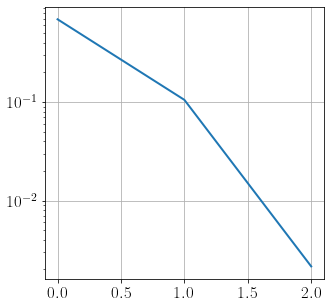

In [10]:
out = 2
# no of momenta states outside cloud, on each side of FS

ins = 1
# no of momenta states inside cloud, on each side of FS

a = 2*out + 1
b = a + 2

U =  [0, 0, 0, 0, 0, 0]
J =  [41.65137072728905, 7.421985528256318, 3.0764876297977835, 1.7632993761561673, 1.1893810568831, 0.8818478505045518]
K =  [0.11014854383139917, 0.10349303670420885, 0.09899373972501821, 0.09516847820969296, 0.09175302137185129, 0.08864547352971129]
V =  [698.7912946938286, 56.013376355019446, 16.783149824539997, 7.729738695156247, 4.4289952117072, 2.887478398100373]

count =  [1, 2, 3, 4, 5, 6]
D =  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

w = -D[0]
j = J[0] * count[0]
k = K[0] * count[0]
v = V[0] * sqrt(count[0])
gamma = (3*j + k + 2*U[0])/(8*v)
csm = sqrt(sqrt(gamma**2 + 4) + gamma)
ccm = -sqrt(sqrt(gamma**2 + 4) - gamma)

iom_above = tensor([basis(2,0)] * 2 * out)
iom_below = tensor([basis(2,1)] * 2 * out)
psi = tensor(iom_above, get_cloud(csm, ccm), iom_below).unit()

I = [mut_inf(psi, a, b)]

for i in range(out):
    args = (U[i+1], J[i+1], K[i+1], V[i+1], D[i+1], w)
    psi = rev_one_step(psi, out, ins, args).unit()
    out -= 1
    ins += 1
    I.append(mut_inf(psi, a, b))

print (I)
plt.plot(I)
plt.yscale("log")
plt.show()